In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from torchvision.utils import save_image, make_grid
from torchvision import transforms
from torchvision.datasets import MNIST

from ddpm import *
from conv_gnn import *

In [2]:
# Load the trained models
def load_trained_models(model_path, ep=None, device='cuda'):
    # Define hyperparameters
    n_T = 400
    n_classes = 10
    n_feat = 128
    
    # Initialize the models
    # Context UNet for the DDPM model
    context_unet = ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes)
    
    # ImageSetGNN model
    distn_ae = ImageSetGNN(
        in_channels=1, hidden_channels=32, out_channels=32, hidden_dim=64, latent_dim=10,
        num_layers=2, kernel_size=3, pool_type='mean', agg_type='mean'
    )
    
    # DDPM model that uses the context UNet
    ddpm = DDPM(nn_model=context_unet, betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
    
    # Load the saved model weights
    if ep is None:
        import os
        # get the latest epoch
        ep = max(int(f.split('_')[1].split('.')[0]) for f in os.listdir(model_path) if f.startswith('model_'))
    ddpm.load_state_dict(torch.load(model_path + f"model_{ep}.pth"))
    distn_ae.load_state_dict(torch.load(model_path + f"distn_ae_{ep}.pth"))
    
    return ddpm, distn_ae

ddpm, distn_ae = load_trained_models('./data/diffusion_outputs10/', 9)

In [3]:
# Function to sample MNIST sets for inference
def sample_mnist_sets(n_sets, set_size):
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = MNIST(root="./data", train=True, download=True, transform=transform)
    
    label_to_indices = {i: torch.where(torch.tensor(dataset.targets) == i)[0] for i in range(10)}
    
    sets = []
    metadata = []
    for _ in range(n_sets):
        label = torch.randint(0, 10, (1,)).item()
        indices = torch.randperm(len(label_to_indices[label]))[:set_size]
        sets.append(dataset.data[label_to_indices[label][indices]].float().unsqueeze(1) / 255.0)
        metadata.append(label)
    
    return torch.stack(sets).float(), metadata

In [4]:
def sample_mnist_mixed_sets(n_sets, set_size, classes_per_set=2):
    # load mnist dataset
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = MNIST(root="./data", train=True, download=True, transform=transform)
    
    # group indices by label
    label_to_indices = {i: torch.where(torch.tensor(dataset.targets) == i)[0] for i in range(10)}
    
    sets = []
    metadata = []
    for _ in range(n_sets):
        mixture_weights = torch.rand(classes_per_set)
        mixture_weights = mixture_weights / mixture_weights.sum()
        set_sizes_per_class = np.random.multinomial(set_size, mixture_weights)
        set_per_class = []
        metadata_per_class = []
        for set_size_per_class in set_sizes_per_class:
            label = torch.randint(0, 10, (1,)).item()  # random label
            indices = torch.randperm(len(label_to_indices[label]))[:set_size_per_class]  # sample set_size images
            set_per_class.append(dataset.data[label_to_indices[label][indices]].float().unsqueeze(1) / 255.0)
            metadata_per_class.append([label, set_size_per_class])
        sets.append(torch.cat(set_per_class, dim=0))
        metadata.append(metadata_per_class)  # store label info
    
    return torch.stack(sets).float(), metadata

In [5]:
def generate_samples(ddpm, distn_ae, n_sample=100, guide_w=2.0, device="cuda" if torch.cuda.is_available() else "cpu"):
    ddpm = ddpm.to(device)
    distn_ae = distn_ae.to(device)

    # Sample some sets to get embeddings
    sample_sets, labels = sample_mnist_mixed_sets(1, 1000)
    sample_sets = sample_sets.to(device)
    
    # Get the distribution embedding using the GNN
    with torch.no_grad():
        c = distn_ae(sample_sets)

        c = c.repeat(n_sample, 1)
        # Generate samples using the diffusion model
        x_gen, x_gen_store = ddpm.sample(c, (1, 28, 28), device)
        #print(c)
    
    return x_gen, x_gen_store, c, labels

# Function to visualize the generated samples
def visualize_samples(x_gen, n_sample=100, n_classes=10):
    # Create a grid of images
    grid = make_grid(x_gen*-1 + 1, nrow=n_classes)
    
    # Plot the grid
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title("Generated MNIST Samples")
    plt.show()

# Function to create a GIF of the generation process
def create_generation_gif(x_gen_store, filename="generation_process.gif", n_sample=40, n_classes=10):
    fig, axs = plt.subplots(nrows=int(n_sample/n_classes), ncols=n_classes, sharex=True, sharey=True, figsize=(10, 5))
    
    def animate_diff(i, x_gen_store):
        print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
        plots = []
        for row in range(int(n_sample/n_classes)):
            for col in range(n_classes):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append(axs[row, col].imshow(-x_gen_store[i, (row*n_classes)+col, 0], 
                                                cmap='gray', 
                                                vmin=(-x_gen_store[i]).min(), 
                                                vmax=(-x_gen_store[i]).max()))
        return plots
    
    ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store], interval=200, 
                       blit=False, repeat=True, frames=x_gen_store.shape[0])
    ani.save(filename, dpi=100, writer=PillowWriter(fps=5))
    print(f'Saved generation process animation to {filename}')

In [6]:
x_gen, x_gen_store, c, labels = generate_samples(ddpm, distn_ae, device='cuda')

/tmp/ipykernel_1601388/874767980.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_to_indices = {i: torch.where(torch.tensor(dataset.targets) == i)[0] for i in range(10)}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1491783].


[[[0, 315], [6, 685]]]


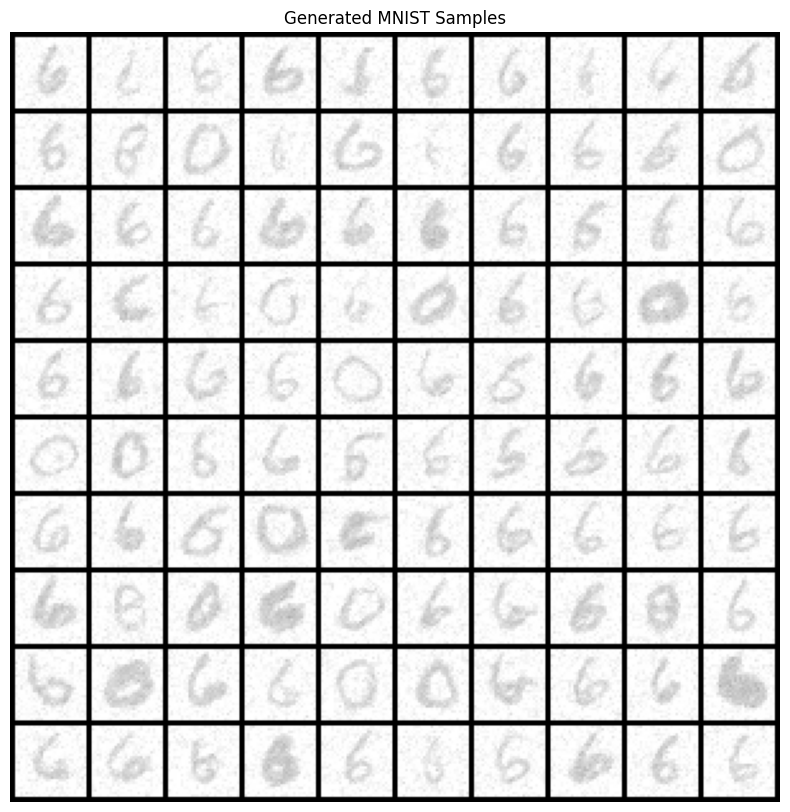

In [7]:
print(labels)
visualize_samples(x_gen, 100)

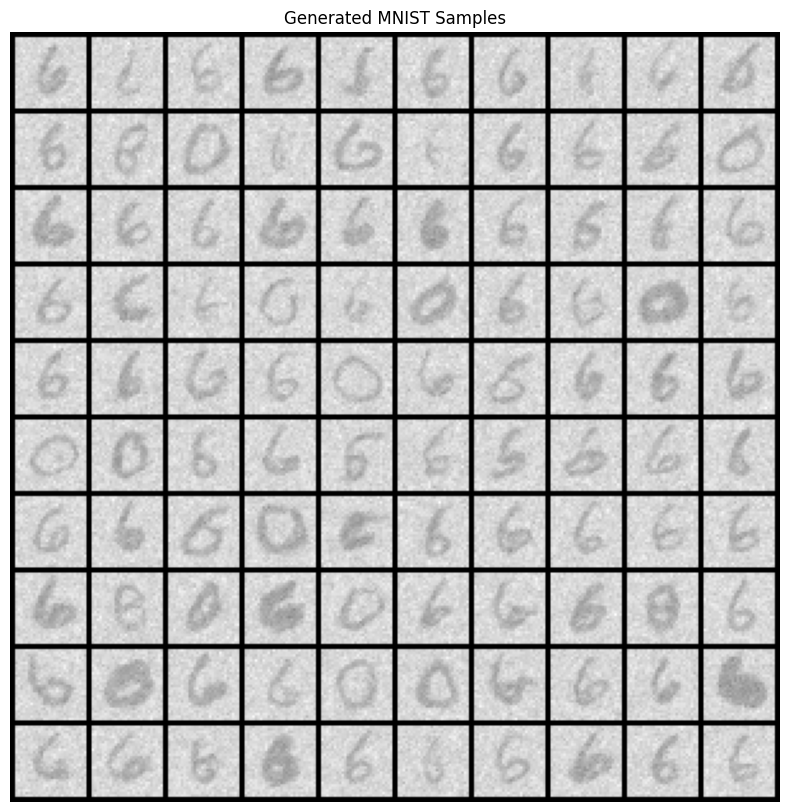

In [8]:
visualize_samples(x_gen - x_gen.min(), 100)